In [1]:
from init import *
import re
from bs4 import BeautifulSoup
from keras import backend as K 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from attention import AttentionLayer
from sklearn.model_selection import train_test_split

autotime loaded.


Using TensorFlow backend.


In [2]:
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

time: 774 µs


In [3]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


time: 7.25 ms


In [4]:
def clean_data(text, summary=False):
    newString = text.lower()
    if not summary:        
        newString = BeautifulSoup(newString, "lxml").text
        newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","", newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    if summary:
        newString = ' '.join([i for i in tokens if len(i) > 1])
    else:
        newString = ' '.join([i for i in tokens if len(i) >= 3]).strip()
    return newString

def tokenize(x_tr, x_val, max_len_text):
    x_tokenizer = Tokenizer()
    x_tokenizer.fit_on_texts(list(x_tr))
    x_tr = x_tokenizer.texts_to_sequences(x_tr) 
    x_val = x_tokenizer.texts_to_sequences(x_val)
    x_tr = pad_sequences(x_tr,  maxlen = max_len_text, padding='post') 
    x_val = pad_sequences(x_val, maxlen = max_len_text, padding='post')
    x_voc_size = len(x_tokenizer.word_index) + 1
    return x_tr, x_val, x_voc_size, x_tokenizer 

time: 6.57 ms


In [5]:
stop_words = set(stopwords.words('english')) 
data = pd.read_csv('Reviews.csv', nrows=100000).drop_duplicates(subset=['Text']).dropna(axis=0)
data['cleaned_text'] = [clean_data(t) for t in data['Text']]    
data['cleaned_summary'] = [clean_data(t, summary=True) for t in data['Summary']]    
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')
for i in range(5):
    print("Review:", data['cleaned_text'][i])
    print("Summary:", data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ advertised _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Summary: 

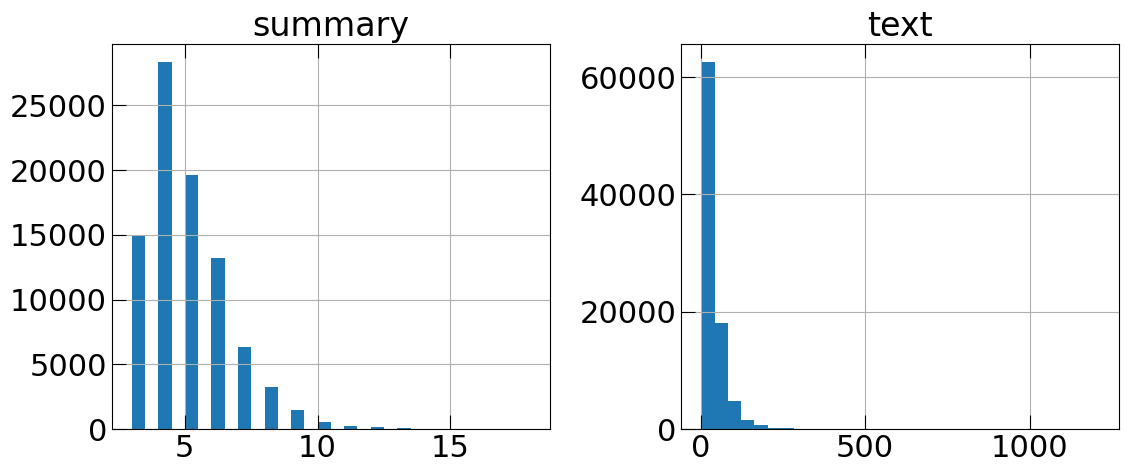

time: 794 ms


In [6]:
length_df = pd.DataFrame([])
length_df['text'] = [len(text.split()) for text in data['cleaned_text']]
length_df['summary'] = [len(text.split()) for text in data['cleaned_summary']]
length_df.hist(bins = 30, figsize=(13, 5))
plt.show()

In [7]:
max_len_text = 80
max_len_summary = 10
x_tr, x_val, y_tr, y_val = train_test_split(data['cleaned_text'], data['cleaned_summary'], 
                                            test_size=0.1, random_state=0, shuffle=True)
x_tr, x_val, x_voc_size, x_tokenizer  = tokenize(x_tr, x_val, max_len_text)
y_tr, y_val, y_voc_size, y_tokenizer  = tokenize(y_tr, y_val, max_len_summary)

time: 9.23 s


In [8]:
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_input = Input(shape=(max_len_text,)) 
encoder_output = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_input) 
for i in range(3):
    encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
    encoder_output, state_h, state_c = encoder_lstm(encoder_output) 

# Decoder
decoder_input = Input(shape=(None,)) 
dec_emb = Embedding(y_voc_size, latent_dim, trainable=True)(decoder_input) 
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_output, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) 

# Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_output, decoder_output]) 

# Concat Layer
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_output, attn_out])
decoder_output = TimeDistributed(Dense(y_voc_size, activation='softmax'))(decoder_concat_input) 

model = Model([encoder_input, decoder_input], decoder_output) 
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      25875000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
_____________________________________________________________________________________________

In [9]:
checkpoint = 'best_model.h5'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint(checkpoint, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit([x_tr, y_tr[:, :-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
                    epochs=12, callbacks=[es, mc], batch_size=512, 
                    validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 79318 samples, validate on 8814 samples
Epoch 1/12
78848/79318 [============================>.] - ETA: 37s - loss: 2.6006 
Epoch 00001: val_loss improved from inf to 2.20844, saving model to best_model.h5
79318/79318 [==============================] - 6600s 83ms/sample - loss: 2.5987 - val_loss: 2.2084
Epoch 2/12
78848/79318 [============================>.] - ETA: 37s - loss: 2.2128 
Epoch 00002: val_loss improved from 2.20844 to 2.09302, saving model to best_model.h5
79318/79318 [==============================] - 6564s 83ms/sample - loss: 2.2119 - val_loss: 2.0930
Epoch 3/12
78848/79318 [============================>.] - ETA: 37s - loss: 2.0816 
Epoch 00003: val_loss improved from 2.09302 to 1.98470, saving model to best_model.h5
79318/79318 [==============================] - 6576s 83ms/sample - loss: 2.0817 - val_loss: 1.9847
Epoch 4/12
78848/79318 [============================>.] -

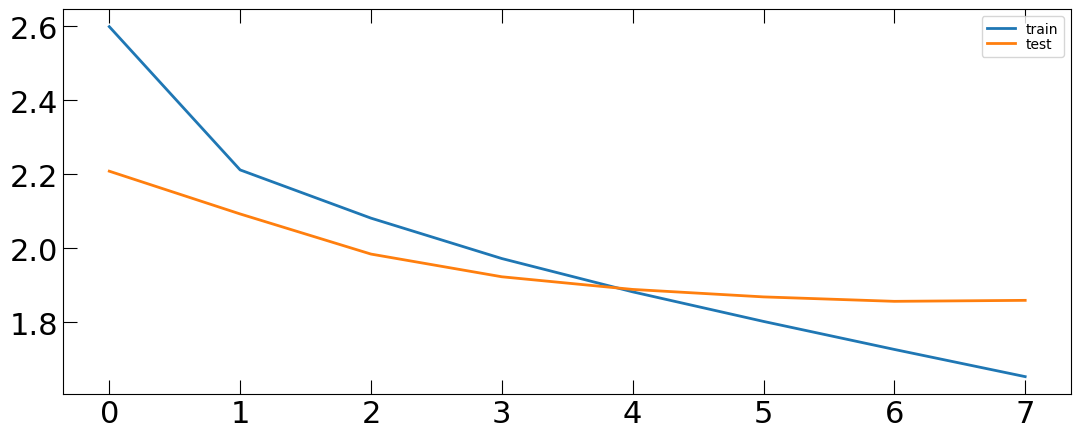

time: 1.07 s


In [10]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(hist.history['loss'], label='train') 
ax.plot(hist.history['val_loss'], label='test') 
ax.legend() 
plt.show()

In [11]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

time: 2.73 ms
